# Atividade 3: xG

## Referências

- [Soccermatics](https://soccermatics.readthedocs.io/en/latest/gallery/lesson2/plot_xGModelFit.html)
- [kloppy](https://kloppy.pysport.org)
- [socceraction](https://socceraction.readthedocs.io/en/latest)
- [socceraction: Wyscout -> SPADL](https://socceraction.readthedocs.io/en/latest/api/generated/socceraction.spadl.wyscout.convert_to_actions.html)
- [socceraction: Statsbomb -> SPADL](https://socceraction.readthedocs.io/en/latest/api/generated/socceraction.spadl.statsbomb.convert_to_actions.html)

## Questão 1

Baixe o dataset [Wyscout Europa Top 5 2017/2018](https://figshare.com/collections/Soccer_match_event_dataset/4415000).

* Vá até o final da página. Lá você vai encontrar múltiplos datasets. O principal é o de Eventos; mas use os demais para adicionar informações (como correspondência id<->jogador)

Escolha uma partida e carregue os dados de eventos em um dataframe do pandas.

In [58]:
import pandas as pd
import json

with open("events_Italy.json", "r", encoding="utf-8") as f:
    events_data = json.load(f)

events_df = pd.DataFrame(events_data)

match_id = 2576062 # Juventus 2-0 Milan
events_match_df = events_df[events_df["matchId"] == match_id]
events_all_df = events_df

print(events_match_df[["eventName", "teamId", "playerId", "eventSec", "matchPeriod"]].head())


       eventName  teamId  playerId   eventSec matchPeriod
173656      Pass    3157    105376   2.314765          1H
173657      Pass    3157     37732   3.832876          1H
173658      Pass    3157      3531   5.487870          1H
173659      Pass    3157    285109   7.388912          1H
173660      Pass    3157    350999  11.288920          1H


### 1.1

Crie um dataframe "shots", contendo apenas os chutes.

Adicione colunas no dataframe "shots" a serem usadas como as features de um modelo de xG.

Justifique a escolha das features.

In [62]:
shots = events_all_df[events_all_df["eventName"] == "Shot"].copy()

import numpy as np

shots["x"] = shots["positions"].apply(lambda pos: pos[0]["x"])
shots["y"] = shots["positions"].apply(lambda pos: pos[0]["y"])

def calculate_distance(x, y):
    goal_x = 100
    goal_y = 50
    return np.sqrt((goal_x - x)**2 + (goal_y - y)**2)

shots["distance"] = shots.apply(lambda row: calculate_distance(row["x"], row["y"]), axis=1)

def calculate_angle(x, y):
    goal_width = 7.32
    a = np.abs(y - 50)
    b = 100 - x
    angle = np.arctan((goal_width * b) / (b**2 + a**2 - (goal_width/2)**2))
    return np.abs(angle)

shots["angle"] = shots.apply(lambda row: calculate_angle(row["x"], row["y"]), axis=1)

def get_body_part(tags):
    tag_ids = [tag["id"] for tag in tags]
    if 401 in tag_ids:
        return "right_foot"
    elif 402 in tag_ids:
        return "left_foot"
    elif 403 in tag_ids:
        return "head"
    else:
        return "other"

shots["body_part"] = shots["tags"].apply(get_body_part)

shots["isGoal"] = shots["tags"].apply(lambda tags: any(tag["id"] == 101 for tag in tags))

print(shots[["x", "y", "distance", "angle", "body_part", "isGoal"]].head())

      x   y   distance     angle   body_part  isGoal
68   80  41  21.931712  0.303418   left_foot   False
90   95  33  17.720045  0.121158  right_foot   False
213  72  63  30.870698  0.214770   left_foot   False
426  91  62  15.000000  0.301824   left_foot   False
435  86  26  27.784888  0.134277  right_foot   False


Para a escolha das features, optei apenas por utilizar a distância, ângulo e parte do corpo do jogador, já que os modelos apresentados não incluem outros fatores como os outros jogadores ou a velocidade do chute. Apesar disso, essas features são mais que suficientes para um bom modelo.

## Questão 2

Agora, crie seu próprio modelo de *expected goals*. Use os slides como guia -- você tem liberdade de usar qualquer método (ex: [regressão logística](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html)).

Reporte a acurácia do modelo para os conjuntos de treino (.score(X_train, y_train)) e teste (.score(X_test, y_test)).

In [64]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score
import pandas as pd
import numpy as np

# Selecionar as features e target
features = shots[["x", "y", "distance", "angle", "body_part"]]
target = shots["isGoal"].astype(int)

# One-hot encode da coluna body_part
features = pd.get_dummies(features, columns=["body_part"], drop_first=True)

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

model = LogisticRegression()
model.fit(X_train, y_train)

train_accuracy = model.score(X_train, y_train)
test_accuracy = model.score(X_test, y_test)

print(f"Acurácia no treino: {train_accuracy:.4f}")
print(f"Acurácia no teste: {test_accuracy:.4f}")

Acurácia no treino: 0.9081
Acurácia no teste: 0.9047


### 2.1

Faça uma curva de calibração para avaliar a qualidade do seu modelo para diferentes probabilidades de gol.

Dica: use a função:

```
from sklearn.calibration import calibration_curve
# calibration_curve(y, y_pred, n_bins=10)
```

Discuta os resultados: seu modelo está *bem calibrado*?


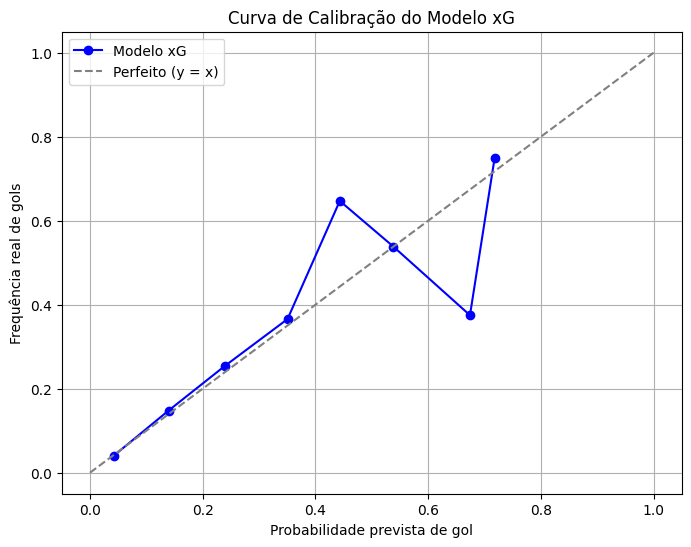

In [65]:
import matplotlib.pyplot as plt
from sklearn.calibration import calibration_curve

# Obter probabilidades previstas
y_pred_prob = model.predict_proba(X_test)[:, 1]  # P(gol)

# Gerar curva de calibração
prob_true, prob_pred = calibration_curve(y_test, y_pred_prob, n_bins=10)

# Plotar
plt.figure(figsize=(8, 6))
plt.plot(prob_pred, prob_true, marker='o', label="Modelo xG", color="blue")
plt.plot([0, 1], [0, 1], linestyle="--", label="Perfeito (y = x)", color="gray")
plt.xlabel("Probabilidade prevista de gol")
plt.ylabel("Frequência real de gols")
plt.title("Curva de Calibração do Modelo xG")
plt.legend()
plt.grid(True)
plt.show()


O modelo começa bem calibrado para valores baixos, porém conforme o xG aumenta ele parece se afastar dos valores ideais, justamente pois não existem gols com chance garantida de serem feitos.

## Questão 3
Aplique o seu model de xG treinado na questão anterior para prever a probabilidade de gol de todos os chutes do dataframe "shots". Reporte essas probabilidades no dataframe "shots" em uma coluna "xG".

Em seguida, crie duas listas, exibindo:
- os 10 jogadores com maior xG
- os 10 jogadores com maior diferença de Gols e xG

Discuta os resultados.
- O seu modelo fez um bom trabalho para prever os gols?
- Como você explica a diferença de gols e xG?

In [66]:
# Reaplicando one-hot encoding no dataframe completo
shots_encoded = pd.get_dummies(shots[["x", "y", "distance", "angle", "body_part"]], columns=["body_part"], drop_first=True)

# Garantir que as colunas estejam na mesma ordem do treino
shots_encoded = shots_encoded.reindex(columns=X_train.columns, fill_value=0)

# Prevendo xG para todos os chutes
shots["xG"] = model.predict_proba(shots_encoded)[:, 1]

top_xg_players = shots.groupby("playerId")["xG"].sum().sort_values(ascending=False).head(10)
print("Top 10 jogadores com maior xG:")
print(top_xg_players)

# Criar coluna de gols como inteiro
shots["Goal"] = shots["isGoal"].astype(int)

# Agrupar por jogador
player_stats = shots.groupby("playerId").agg({"Goal": "sum", "xG": "sum"})
player_stats["G - xG"] = player_stats["Goal"] - player_stats["xG"]

# Ordenar pela diferença
top_diff_players = player_stats.sort_values(by="G - xG", ascending=False).head(10)
print("\nTop 10 jogadores com maior diferença G - xG:")
print(top_diff_players)


Top 10 jogadores com maior xG:
playerId
8327      18.910786
206314    15.060569
269152    13.496628
22933     12.957135
21385     12.385319
21234     11.687876
21384     11.600654
333913    11.282372
20479     10.953813
3323      10.132060
Name: xG, dtype: float64

Top 10 jogadores com maior diferença G - xG:
          Goal         xG     G - xG
playerId                            
21384       22  11.600654  10.399346
89186       16   6.634377   9.365623
206314      23  15.060569   7.939431
3318         9   3.495351   5.504649
265865      12   6.531750   5.468250
3323        15  10.132060   4.867940
8148        12   7.566072   4.433928
25601        8   3.792438   4.207562
20845        8   4.079844   3.920156
130          6   2.334074   3.665926


O modelo parece funcionar bem, já que os jogadores com mais gols são aqueles com os maiores xG, porém, parece que todos eles apresentam-se fazendo mais gols que o esperado, sem exceção, o que pode indicar que talvez o modelo tenda a esperar menos gols do que deveria.

## Questão 4 (opcional)
Carregue os [dados das 5 grandes ligas européias do StatsBomb](https://statsbomb.com/news/the-2015-16-big-5-leagues-free-data-release-la-liga/). Use o [guia do statsbomb para carregar os dados](https://statsbomb.com/articles/soccer/using-statsbomb-free-data-in-python/), se quiser.

Note que as métricas e o formato dos dados são diferentes.

Com os dados da StatsBomb, crie um novo modelo de xG. Você pode usar as mesmas ideias do modelo da questão 1, ou pode fazer um modelo novo.

Compare e discuta seus resultados.